In [1]:
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA, SparsePCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.model_selection import cross_val_score, learning_curve, train_test_split
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.manifold import TSNE
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sn
import altair as alt
from tqdm import tqdm
import numpy as np
import time
from statsmodels.stats.outliers_influence import variance_inflation_factor


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Cleaning

In [3]:
path = '/ISTdata.csv'
path = '/content/drive/MyDrive/ISTdata.csv'
IST_df = pd.read_csv(path)
df = IST_df.copy()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.



In [4]:
def data_split(df, multi_class=True):
  if multi_class == True:
    X_data = df.drop(columns=['STYPE'])
    y_data = df[['STYPE']]
  else:
    df = df[df['FDEAD'].notnull()]
    df = df[df['FDEAD'] != 'U']
    X_data = df.drop(columns=['FDEAD'])
    y_data = df[['FDEAD']]
    y_data = y_data.replace('N', 0)
    y_data = y_data.replace('n', 0)
    y_data = y_data.replace('Y', 1)
    y_data = y_data.replace('y', 1)    

  X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.20, random_state=42)

  return X_train, X_test, y_train, y_test

X_train_multi = data_split(df)[0]
X_test_multi = data_split(df)[1]
y_train_multi = data_split(df)[2]
y_test_multi = data_split(df)[3]

X_train_binary = data_split(df, multi_class=False)[0]
X_test_binary = data_split(df, multi_class=False)[1]
y_train_binary = data_split(df, multi_class=False)[2]
y_test_binary = data_split(df, multi_class=False)[3]

def clean(df, multi_class=True):
  X_df = df.copy().reset_index()
  X_df = X_df.replace('C',np.NaN)
  X_df['RCONSC'] = X_df['RCONSC'].replace('U', 'UN')
  X_df['RXHEP'] = X_df['RXHEP'].replace('H', 25000)
  X_df['RXHEP'] = X_df['RXHEP'].replace('M', 25000)
  X_df['RXHEP'] = X_df['RXHEP'].replace('L', 10000)
  X_df['RXHEP'] = X_df['RXHEP'].replace('N', 0)

  X_df = X_df.replace('U',np.NaN)
  X_df = X_df.replace('u',np.NaN)
  X_df = X_df.replace('N', 0)
  X_df = X_df.replace('n', 0)
  X_df = X_df.replace('Y', 1)
  X_df = X_df.replace('y', 1)

  columns_dropped = ['HOSPNUM','RDATE','RVISINF','HOURLOCAL','MINLOCAL','DMAJNCHD','DMAJNCHX','DSIDE','DSIDEX','DSIDED','DNOSTRKX','DRSISCD','DRSH','DRSHD','DRSUNK','DRSUNKD',
                    'DPED', 'DALIVE', 'DALIVED', 'DPLACE', 'DDEAD', 'DDEADD', 'DDEADC', 'DDEADX','FLASTD', 'FDEADD', 'FDEADC', 'FDEADX', 'FRECOVER', 'FDENNIS', 'FPLACE',
                    'FAP', 'FOAC', ' FU1_RECD ', ' FU2_DONE ', 'COUNTRY', 'CNTRYNUM', 'FU1_COMP', 'NCCODE', 'CMPLASP', 'CMPLHEP', 'DIED', 'TD', 'EXPDD', 'EXPD6', 'EXPD14',
                    'SET14D', 'ID14','DEAD1', 'DEAD2', 'DEAD3', 'DEAD4', 'DEAD5', 'DEAD6', 'DEAD7', 'DEAD8', 'H14', 'ISC14', 'NK14', 'STRK14', 'HTI14', 'PE14', 'DVT14',
                    'TRAN14', 'NCB14']
  X_df = X_df.drop(columns=columns_dropped)

  enc = OneHotEncoder()

  if multi_class==True:
    enc.fit(X_df[['RCONSC','SEX']])
    onehotlabels = enc.transform(X_df[['RCONSC','SEX']]).toarray()
    OHE_df = pd.DataFrame(onehotlabels, columns=['RCONSC_ALERT','RCONSC_DROWS','RCONSC_UNCONS','SEX_F','SEX_M'])

    X_data = X_df.merge(OHE_df, left_index=True, right_index=True)
    X_data = X_data.drop(columns=['RCONSC','SEX','index'])
  else:
    enc.fit(X_df[['RCONSC','SEX', 'STYPE']])
    onehotlabels = enc.transform(X_df[['RCONSC','SEX','STYPE']]).toarray()
    OHE_df = pd.DataFrame(onehotlabels, columns=['RCONSC_ALERT','RCONSC_DROWS','RCONSC_UNCONS','SEX_F','SEX_M',
                                                 'STYPE_LACS', 'STYPE_OTH', 'STYPE_PACS', 'STYPE_POCS', 'STYPE_TACS',])

    X_data = X_df.merge(OHE_df, left_index=True, right_index=True)
    X_data = X_data.drop(columns=['RCONSC','SEX','index','OCCODE', 'STYPE'])


  return X_data

X_train_clean = clean(X_train_multi)
X_train_clean_binary = clean(X_train_binary, multi_class=False)


In [5]:
X_train_clean.head(5)

,RDELAY,AGE,RSLEEP,RATRIAL,RCT,RHEP24,RASP3,RSBP,RDEF1,RDEF2,RDEF3,RDEF4,RDEF5,RDEF6,RDEF7,RDEF8,DAYLOCAL,RXASP,RXHEP,DASP14,DASPLT,DLH14,DMH14,DHH14,ONDRUG,DSCH,DIVH,DAP,DOAC,DGORM,DSTER,DCAA,DHAEMD,DCAREND,DTHROMB,DMAJNCH,DDIAGISC,DDIAGHA,DDIAGUN,DNOSTRK,DRSISC,DPE,FDEAD,OCCODE,RCONSC_ALERT,RCONSC_DROWS,RCONSC_UNCONS,SEX_F,SEX_M
0,24,77,0,0.0,0,0.0,1.0,130,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,5,0,0,0.0,1.0,0.0,0.0,NaN,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.0,1.0,0.0,0.0,1.0
1,40,83,0,1.0,1,1.0,0.0,220,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,7,1,0,1.0,1.0,0.0,0.0,NaN,13.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0,1.0,0.0,1.0,0.0
2,1,77,0,1.0,0,0.0,0.0,170,1.0,1.0,1.0,1.0,NaN,1.0,0.0,NaN,3,0,0,0.0,1.0,0.0,0.0,NaN,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1.0,0.0,0.0,1.0,0.0
3,2,75,0,0.0,0,0.0,0.0,150,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2,1,0,1.0,1.0,0.0,0.0,NaN,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.0,1.0,0.0,0.0,1.0
4,8,86,0,1.0,1,0.0,0.0,190,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,7,1,0,1.0,1.0,0.0,0.0,NaN,13.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1.0,0.0,0.0,1.0,0.0


## Missing Values

In [6]:
def missing_values():
    
  missing_values_count = df.isnull().sum()
  miss_values_df = pd.DataFrame(missing_values_count)
  miss_values_df = miss_values_df[miss_values_df[0] > 0].reset_index()
  miss_values_df = miss_values_df.rename(columns={0:'count'})
  miss_values_df = miss_values_df[miss_values_df['count'] > 0]
  chart = alt.Chart(miss_values_df
          ).mark_bar().encode(
              x= alt.X('count'),
              y= alt.Y('index',
                       title='Indicator',
                       sort='-x'))
          
  return chart

missing_values()

alt.Chart(...)

## Imbalance Check

In [7]:
def bar_plot_age(column):

  
  count_age = df[column].value_counts().reset_index()
  chart = alt.Chart(count_age
          ).mark_bar().encode(
              x=alt.X('index',
              title='',
              sort=alt.EncodingSortField(field="index",
                                         op="count",
                                         order='ascending')),
              y=alt.Y(column)
                                         
          )
  return chart

top = bar_plot_age('AGE') | bar_plot_age('SEX')
bottom = bar_plot_age('STYPE') | bar_plot_age('FDEAD')
alt.vconcat(top,bottom)

alt.VConcatChart(...)

# Scaling

In [8]:
def scaling(dataset):

  scaler = MinMaxScaler()
  scaled_df = pd.DataFrame(scaler.fit_transform(dataset), columns = dataset.columns)

  imputer = KNNImputer(n_neighbors=5)
  filled_scaled_df = pd.DataFrame(imputer.fit_transform(scaled_df),columns = scaled_df.columns)
  return filled_scaled_df

X_filled_scaled_df = scaling(X_train_clean)
X_binary_filled_scaled_df = scaling(X_train_clean_binary)

In [9]:
#calculate VIF for correlation
def v(X):

    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)


v(X_filled_scaled_df)

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning:

divide by zero encountered in double_scalars



,variables,VIF
0,RDELAY,1.073990
1,AGE,1.257304
2,RSLEEP,1.012271
3,RATRIAL,1.132959
4,RCT,1.221167
5,RHEP24,1.013611
6,RASP3,1.032927
7,RSBP,1.031678
8,RDEF1,1.234265
9,RDEF2,1.812311


# PCA

In [10]:
def extract_features_PCA(filled_scaled_df):

  pca = PCA(n_components=30).fit(X_filled_scaled_df)
  X_pca = pca.transform(X_filled_scaled_df)
  return X_pca, pca

X_pca = extract_features_PCA(X_filled_scaled_df)[0]
pca = extract_features_PCA(X_filled_scaled_df)[1]

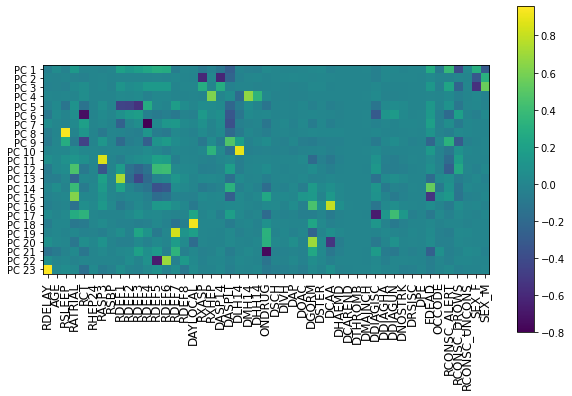

In [24]:
def plot_pca(pca, top_k = 23, sparse=False):
    if sparse == False:
      fig, ax = plt.subplots(figsize=(10, 6))
      plt.imshow(pca.components_[0:top_k], interpolation = 'none', cmap = 'viridis')
      feature_names=list(X_filled_scaled_df.columns)
      labels = ['PC '+str(i) for i in range(1, top_k+1)]
      plt.xticks(np.arange(-0., len(feature_names), 1) , feature_names, rotation = 90, fontsize=12)
      plt.yticks(np.arange(0., top_k, 1), labels, fontsize = 10)
      plt.colorbar()
    elif sparse == True:
      fig, ax = plt.subplots(figsize=(10, 6))
      plt.imshow(pca.components_[0:2], interpolation = 'none', cmap = 'viridis')
      feature_names=list(X_filled_scaled_df.columns)
      # labels = ['PC '+str(i) for i in range(1, top_k+1)]
      plt.xticks(np.arange(-0., len(feature_names), 1) , feature_names, rotation = 90, fontsize=12)
      plt.yticks(np.arange(0., 2, 1), ['PCA 1', 'PCA 2'], fontsize = 10)
      plt.colorbar()      
    
plot_pca(pca, sparse=False)

(<matplotlib.axes._subplots.AxesSubplot at 0x7fb09f775510>,
                            0         1         2   ...        27        28        29
 explained var ratio  0.121022  0.216842  0.305988  ...  0.945315  0.951708  0.956603
 
 [1 rows x 30 columns])

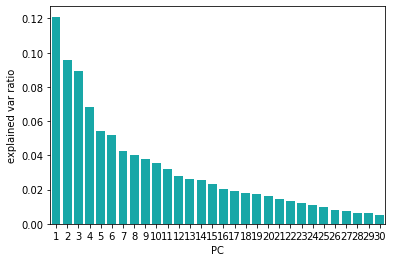

In [12]:
def scree_plot(pca):

  labels = [i for i in range(1, len(pca.explained_variance_ratio_)+1)]
  df = pd.DataFrame({'explained var ratio': (pca.explained_variance_ratio_),
                    'PC':labels})
  plot = sn.barplot(x = 'PC',y = "explained var ratio", data = df, color="c");
  table = np.cumsum(df['explained var ratio'])
  return plot, pd.DataFrame(table).T

scree_plot(pca)

In [22]:
def sparse_PCA(dframe):
  pca_sparse = SparsePCA(n_components=2, alpha = 1, random_state=42)
  pca_sparse.fit(dframe)
  X_transformed = pca_sparse.transform(X_filled_scaled_df)
  
  return pca_sparse, X_transformed
  
pca_sparse = sparse_PCA(X_filled_scaled_df)[0]
X_transformed = sparse_PCA(X_filled_scaled_df)[1]


38.78% of values are zero in Sparse PCA first component.


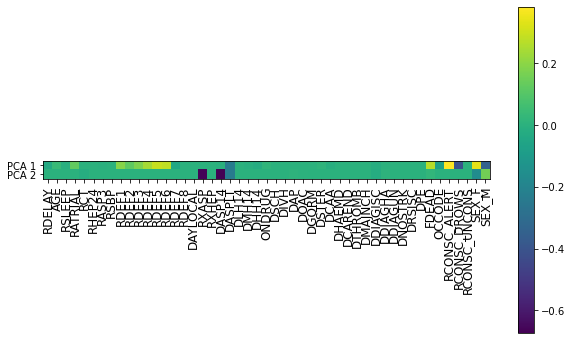

In [25]:
percentage = np.sum(pca_sparse.components_[0] == 0)/len(pca_sparse.components_[0])
print('{:2.2%} of values are zero in Sparse PCA first component.'.format(percentage))
plot_pca(pca_sparse, sparse=True)

# tSNE

In [ ]:
def tSNE(dframe):

  time_start = time.time()
  tsne = TSNE(n_components=2, perplexity = 50, n_iter=300)
  tsne_results = tsne.fit_transform(X_filled_scaled_df)

  one = tsne_results[:,0]
  two = tsne_results[:,1]

  return one, two

one = tSNE(X_filled_scaled_df)[0]
two = tSNE(X_filled_scaled_df)[1]

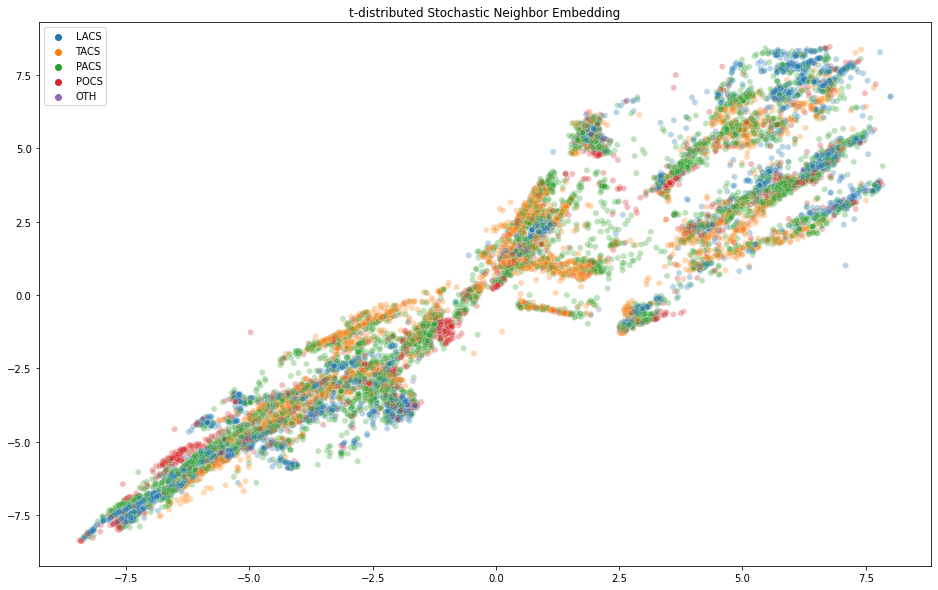

In [ ]:
def plot_tSNE(one,two):

  plt.figure(figsize=(16,10))
  chart = sn.scatterplot(
      x=one, y=two,
      hue=list(y_train_multi['STYPE']),
      legend="full",
      alpha=0.3
  )
  chart.set_title("t-distributed Stochastic Neighbor Embedding")
  return chart

plot_tSNE(one,two)


# DBSCAN

In [ ]:
def knn_cv_scores(y_train):
  # Creating odd list K for KNN
  neighbors = list(range(1,50,2))
  # empty list that will hold cv scores
  cv_scores = [ ]
  #perform 10-fold cross-validation
  for K in tqdm(neighbors):
      knn = KNeighborsClassifier(n_neighbors = K)
      scores = cross_val_score(knn,X_filled_scaled_df,np.ravel(y_train,order='C'),cv = 10,scoring =
      "accuracy")
      cv_scores.append(scores.mean())
  return cv_scores

cv_scores = knn_cv_scores(y_train_multi)

100%|██████████| 25/25 [10:05<00:00, 24.20s/it]


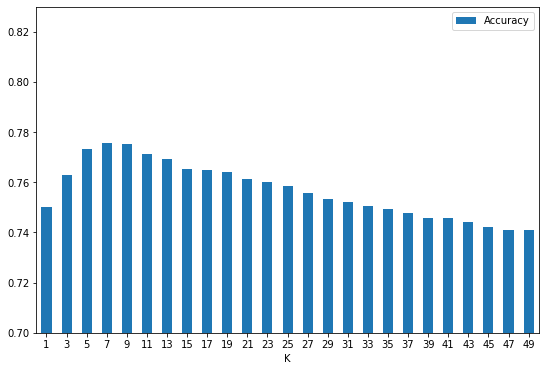

In [ ]:
def plot_accuracy(knn_list_scores):
    pd.DataFrame({"K":[i for i in range(1,50,2)], "Accuracy":knn_list_scores}).set_index("K").plot.bar(figsize= (9,6),ylim=(0.70,0.83),rot=0)
    plt.show()
plot_accuracy(cv_scores)


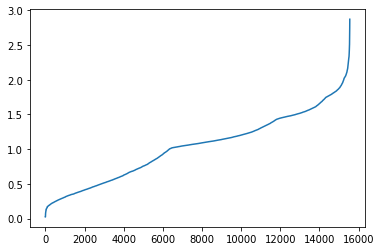

In [ ]:
neigh = NearestNeighbors(n_neighbors=7)
nbrs = neigh.fit(X_filled_scaled_df)
distances, indices = nbrs.kneighbors(X_filled_scaled_df)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [ ]:
scan = DBSCAN(eps=1.4, min_samples=12, metric="euclidean")
cls = scan.fit_predict(X_filled_scaled_df)
#1.3 and 10 and 1.4 and 12 1.45 and 6
#0.1 and 2 for sparse PCA

In [ ]:
get_labels_df = pd.DataFrame(scan.labels_)
set(scan.labels_)
get_labels_df.value_counts()


-1     6317
 0     4321
 2     3124
 3      769
 4      638
 7       92
 5       90
 1       55
 10      47
 8       27
 6       22
 9       21
 11      13
 12      12
dtype: int64

In [ ]:
labels = scan.labels_
alt_df = pd.DataFrame([one,two,labels]).T
alt_df = alt_df.rename(columns={0:'one',1:'two',2:'labels'})

selection = alt.selection_multi(fields=['labels'], bind='legend')
alt.data_transformers.disable_max_rows()
chart = alt.Chart(alt_df).mark_circle().encode(x=alt.X('one'),
                                       y=alt.Y('two'),
                                       color=alt.Color('labels:N', scale=alt.Scale(scheme='viridis')),
                                       opacity=alt.condition(selection, alt.value(.8), alt.value(0))).add_selection(selection)
chart

alt.Chart(...)

# Training Data Learning Curve

In [ ]:
X_clean_stype = clean(X_train_multi)
X_clean_binary = clean(X_train_binary, multi_class=False)

X_train_stype = scaling(X_clean_stype)
X_train_binary = scaling(X_clean_binary)

In [ ]:
X_test_clean_multi = clean(X_test_multi)
X_test_clean_binary = clean(X_test_binary, multi_class=False)
X_test_multi_scaled = scaling(X_test_clean_multi)
X_test_binary_scaled = scaling(X_test_clean_binary)

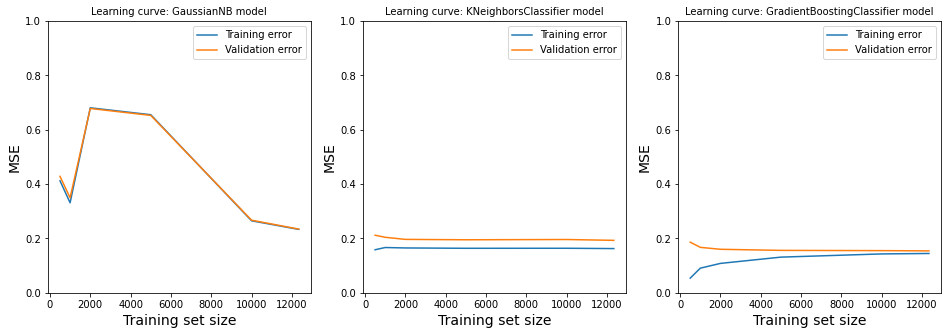

In [ ]:
train_size = [500, 1000, 2000, 5000, 10000, 12338]
def training_data_curve(estimator, X_train, y_train, train_sizes, cv):
    train_sizes, train_scores, validation_scores = learning_curve(estimator, X_train, y_train,
                                                                  train_sizes = train_sizes, cv = cv,
                                                                  scoring = 'neg_mean_squared_error')
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

    plt.ylabel('MSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curve: ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 10)
    plt.legend()
    plt.ylim(0,1)

plt.figure(figsize = (16,5))

for model, i in [(GaussianNB(), 1), (KNeighborsClassifier(n_neighbors = 9),2), (GradientBoostingClassifier(), 3)]:
    plt.subplot(1,3,i)
    training_data_curve(model, X_train_binary, y_train_binary['FDEAD'], train_size, 5)


# Classifiers

In [ ]:
#Naive Bayes for multi-classification and binary classification of stroke and 6 months mortality, respectively
gnb_multi = GaussianNB().fit(X_train_stype, y_train_multi['STYPE'])
multi = gnb_multi.score(X_test_multi_scaled, y_test_multi['STYPE'])
gnb_binary = GaussianNB().fit(X_train_binary, y_train_binary['FDEAD'])
binary = gnb_binary.score(X_test_binary_scaled, y_test_binary['FDEAD'])

print('Benchmark Mean Accuracy for Stroke Types (Naive Bayes):', multi)
print('Benchmark Mean Accuracy for Death at 6 Months (Naive Bayes):', binary)

Benchmark Mean Accuracy for Stroke Types (Naive Bayes): 0.7200926164136866
Benchmark Mean Accuracy for Death at 6 Months (Naive Bayes): 0.762707468879668


In [ ]:
#KNN for multi-classification and binary classification of stroke and 6 months mortality, respectively
#n_neighbors was predicted through Aidan's K-means optimization
knn_multi = KNeighborsClassifier(n_neighbors = 9, weights ='distance').fit(X_train_stype, y_train_multi['STYPE'])
multi = knn_multi.score(X_test_multi_scaled, y_test_multi['STYPE'])
knn_binary = KNeighborsClassifier(n_neighbors = 9).fit(X_train_binary, y_train_binary['FDEAD'])
binary = knn_binary.score(X_test_binary_scaled, y_test_binary['FDEAD'])

print('Mean Accuracy for Stroke Types (KNN):', multi)
print('Mean Accuracy for Death at 6 Months (KNN):', binary)

Mean Accuracy for Stroke Types (KNN): 0.7851813738101363
Mean Accuracy for Death at 6 Months (KNN): 0.8065352697095436


In [ ]:
#Ablation test for Knn, binary
def score_model_knn(X_train, X_test, y_train, y_test):
  knn = KNeighborsClassifier(n_neighbors = 9)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  return accuracy_score(y_test, y_pred)

base_score = score_model_knn(X_train_binary,
                             X_test_binary_scaled,
                             y_train_binary['FDEAD'],
                             y_test_binary['FDEAD'])

scores_binary = []
for i in tqdm(list(X_train_binary.columns)):
  use_column = list(X_train_binary.columns)
  use_column.remove(i)
  scores_binary.append(score_model_knn(X_train_binary[use_column],
                                       X_test_binary_scaled[use_column],
                                       y_train_binary['FDEAD'],
                                       y_test_binary['FDEAD']))
  
top_10 = sorted(enumerate([base_score - s for s in scores_binary]),
              key=lambda ndx_score: ndx_score[1],
              reverse=True)[:10]

[list(X_train_binary.columns)[top_10[i][0]] for i in range(10)]



100%|██████████| 52/52 [07:28<00:00,  8.63s/it]


['DASPLT',
 'ONDRUG',
 'RHEP24',
 'DOAC',
 'RDEF5',
 'DRSISC',
 'DCAA',
 'DHH14',
 'RCONSC_UNCONS',
 'STYPE_TACS']

In [ ]:
#Ablation test for Knn, multi
def score_model_knn(X_train, X_test, y_train, y_test):
  knn = KNeighborsClassifier(n_neighbors = 9, weights ='distance')
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  return accuracy_score(y_test, y_pred)

base_score = score_model_knn(X_train_stype,
                             X_test_multi_scaled,
                             y_train_multi['STYPE'],
                             y_test_multi['STYPE'])

scores_multi = []
for i in tqdm(list(X_train_stype.columns)):
  use_column = list(X_train_stype.columns)
  use_column.remove(i)
  scores_multi.append(score_model_knn(X_train_stype[use_column],
                                       X_test_multi_scaled[use_column],
                                       y_train_multi['STYPE'],
                                       y_test_multi['STYPE']))
  
top_10 = sorted(enumerate([base_score - s for s in scores_multi]),
              key=lambda ndx_score: ndx_score[1],
              reverse=True)[:10]

[list(X_train_stype.columns)[top_10[i][0]] for i in range(10)]

100%|██████████| 49/49 [06:41<00:00,  8.19s/it]


['RDEF4',
 'RDEF5',
 'RDEF7',
 'RDEF6',
 'RDEF3',
 'RDEF1',
 'RDEF2',
 'RHEP24',
 'RSBP',
 'RDEF8']

In [ ]:
#GBDT for multi-classification and binary classification of stroke and 6 months mortality, respectively
clf = GradientBoostingClassifier(learning_rate = .1, max_depth=5, random_state=42)
clf.fit(X_train_stype, y_train_multi['STYPE'])
multi = clf.score(X_test_multi_scaled, y_test_multi['STYPE'])

clf_bin = GradientBoostingClassifier(learning_rate = .01, max_depth=7, random_state=42, n_estimators=300)
clf_bin.fit(X_train_binary, y_train_binary['FDEAD'])
binary = clf_bin.score(X_test_binary_scaled, y_test_binary['FDEAD'])

print('Mean Accuracy for Stroke Types (GBDT):', multi)
print('Mean Accuracy for Death at 6 Months (GBDT):', binary)

Mean Accuracy for Stroke Types (GBDT): 0.9773604322099305
Mean Accuracy for Death at 6 Months (GBDT): 0.8412863070539419


In [ ]:
#GBDT for binary classification of death at 6-months classification report

clf_binary_predicted = clf_bin.predict(X_test_binary_scaled)
# confusion_matrix(y_test_binary['FDEAD'], clf_binary_predicted)

print('Accuracy: {:.2f}'.format(accuracy_score(y_test_binary['FDEAD'], clf_binary_predicted)))
print('Precision: {:.2f}'.format(precision_score(y_test_binary['FDEAD'], clf_binary_predicted)))
print('Recall: {:.2f}'.format(recall_score(y_test_binary['FDEAD'], clf_binary_predicted)))
print('F1: {:.2f}'.format(f1_score(y_test_binary['FDEAD'], clf_binary_predicted)))
print(classification_report(y_test_binary['FDEAD'], clf_binary_predicted))

Accuracy: 0.84
Precision: 0.74
Recall: 0.44
F1: 0.55
              precision    recall  f1-score   support

           0       0.86      0.96      0.90      3001
           1       0.74      0.44      0.55       855

    accuracy                           0.84      3856
   macro avg       0.80      0.70      0.73      3856
weighted avg       0.83      0.84      0.83      3856



In [ ]:
#Ablation test for GBDT, binary
def score_model_gbdt(X_train, X_test, y_train, y_test):
  clf = GradientBoostingClassifier(learning_rate = .01, max_depth=7, random_state=42, n_estimators=300)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  return accuracy_score(y_test, y_pred)

base_score = score_model_gbdt(X_train_binary,
                              X_test_binary_scaled,
                              y_train_binary['FDEAD'],
                              y_test_binary['FDEAD'])

scores_binary = []
for i in tqdm(list(X_train_binary.columns)):
  use_column = list(X_train_binary.columns)
  use_column.remove(i)
  scores_binary.append(score_model_gbdt(X_train_binary[use_column],
                                        X_test_binary_scaled[use_column],
                                        y_train_binary['FDEAD'],
                                        y_test_binary['FDEAD']))
  
top_10 = sorted(enumerate([base_score - s for s in scores_binary]),
              key=lambda ndx_score: ndx_score[1],
              reverse=True)[:10]

[list(X_train_binary.columns)[top_10[i][0]] for i in range(10)]

100%|██████████| 52/52 [15:47<00:00, 18.22s/it]


['DASPLT',
 'ONDRUG',
 'AGE',
 'DOAC',
 'RDEF1',
 'RCONSC_DROWS',
 'RXASP',
 'STYPE_TACS',
 'DSTER',
 'RDEF3']

In [ ]:
#Ablation test for GBDT, multi
def score_model_gbdt(X_train, X_test, y_train, y_test):
  clf = GradientBoostingClassifier(learning_rate = .1, max_depth=5, random_state=42)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  return accuracy_score(y_test, y_pred)

base_score = score_model_gbdt(X_train_stype,
                              X_test_multi_scaled,
                              y_train_multi['STYPE'],
                              y_test_multi['STYPE'])

scores_multi = []
for i in tqdm(list(X_train_stype.columns)):
  use_column = list(X_train_stype.columns)
  use_column.remove(i)
  scores_multi.append(score_model_gbdt(X_train_stype[use_column],
                                       X_test_multi_scaled[use_column],
                                       y_train_multi['STYPE'],
                                       y_test_multi['STYPE']))
  
top_10 = sorted(enumerate([base_score - s for s in scores_multi]),
              key=lambda ndx_score: ndx_score[1],
              reverse=True)[:10]

[list(X_train_stype.columns)[top_10[i][0]] for i in range(10)]

100%|██████████| 49/49 [15:10<00:00, 18.58s/it]


['RDEF4',
 'RDEF5',
 'RDEF7',
 'RDEF6',
 'RDEF1',
 'RDEF2',
 'RDEF3',
 'RDEF8',
 'RDELAY',
 'AGE']

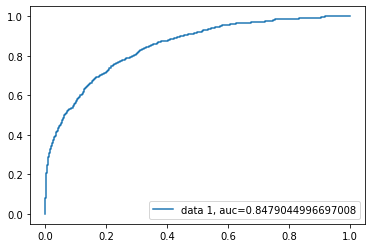

In [ ]:
#GBDT ROC-AUC curve for binary classification of death at 6-months classification report
y_pred_prob = clf_bin.predict_proba(X_test_binary_scaled)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test_binary['FDEAD'],  y_pred_prob)
auc = metrics.roc_auc_score(y_test_binary['FDEAD'],  y_pred_prob)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
clf_multi_predicted = clf.predict(X_test_multi_scaled)

print(classification_report(y_test_multi['STYPE'], clf_multi_predicted))

              precision    recall  f1-score   support

        LACS       0.97      1.00      0.98       893
         OTH       0.67      1.00      0.80         8
        PACS       0.98      0.97      0.97      1622
        POCS       1.00      1.00      1.00       445
        TACS       0.98      0.96      0.97       919

    accuracy                           0.98      3887
   macro avg       0.92      0.99      0.95      3887
weighted avg       0.98      0.98      0.98      3887



Text(0.5, 15.0, 'Predicted label')

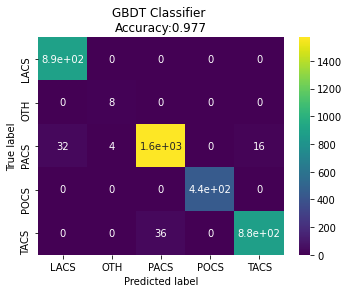

In [ ]:
#confusion matrix for GBDT classifier for multi-classification of stroke type
confusion_mc = confusion_matrix(np.array(y_test_multi['STYPE']), clf_multi_predicted)
df_cm = pd.DataFrame(confusion_mc, 
                     index = ['LACS', 'OTH', 'PACS', 'POCS', 'TACS'], columns = ['LACS', 'OTH', 'PACS', 'POCS', 'TACS'])

plt.figure(figsize=(5.5,4))
sn.heatmap(df_cm, annot=True, cmap='viridis')
plt.title('GBDT Classifier \nAccuracy:{0:.3f}'.format(accuracy_score(y_test_multi['STYPE'], 
                                                                       clf_multi_predicted)))
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
#SVM for binary classification of death at 6-months
svm = SVC(kernel='rbf', C=1, gamma=0.1).fit(X_train_binary, y_train_binary['FDEAD'])
svm.score(X_test_binary_scaled, y_test_binary['FDEAD'])

0.8405082987551867

In [ ]:
#GridSearchCV for binary classification of death at 6-months
X_test_filled_scaled_df_binary = scaling(X_test_clean_binary)
svm = SVC(kernel='rbf')
grid_values = {'gamma': [0.001, 0.01, 0.05, 0.1, 1, 10, 100]}

# default metric to optimize over grid parameters: accuracy
grid_clf_acc = GridSearchCV(svm, param_grid = grid_values)
grid_clf_acc.fit(X_binary_filled_scaled_df, y_train_binary['FDEAD'])
y_decision_fn_scores_acc = grid_clf_acc.decision_function(X_test_filled_scaled_df_binary) 

print('Grid best parameter (max. accuracy): ', grid_clf_acc.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc.best_score_)


Grid best parameter (max. accuracy):  {'gamma': 0.1}
Grid best score (accuracy):  0.8360241913614892


# Aidan's work

## Imputation

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train_clean_binary)
X_train_imputed = pd.DataFrame(imp.transform(X_train_clean_binary), columns=X_train_clean_binary.columns)
X_train_imputed_scaled = scaling(X_train_imputed)

In [ ]:
#Naive Bayes Classifier for multi-classification of stroke types, unscaled
gnb_u = GaussianNB().fit(X_train_imputed, y_train_binary.values.ravel())

#Naive Bayes Classifier for multi-classification of stroke types, scaled
gnb_s = GaussianNB().fit(X_train_imputed_scaled, y_train_binary.values.ravel())

print("unscaled:" + str(gnb_u.score(X_train_imputed, y_train_binary.values.ravel())))
print("scaled:" + str(gnb_s.score(X_train_imputed_scaled, y_train_binary.values.ravel())))

#### GBC performance, unscaled

In [ ]:
clf_bin = GradientBoostingClassifier(learning_rate = 1, max_depth=5, random_state=42, n_estimators=500)
clf_bin.fit(X_train_imputed, y_train_binary.values.ravel())

X_test_clean_binary = clean(X_test_binary, multi_class=False)
X_test_filled_scaled_df_binary = scaling(X_test_clean_binary)

clf_binary_predicted = clf_bin.predict(X_test_filled_scaled_df_binary)
# confusion_matrix(y_test_binary['FDEAD'], clf_binary_predicted)

print('Accuracy: {:.2f}'.format(accuracy_score(y_test_binary['FDEAD'], clf_binary_predicted)))
print('Precision: {:.2f}'.format(precision_score(y_test_binary['FDEAD'], clf_binary_predicted)))
print('Recall: {:.2f}'.format(recall_score(y_test_binary['FDEAD'], clf_binary_predicted)))
print('F1: {:.2f}'.format(f1_score(y_test_binary['FDEAD'], clf_binary_predicted)))
print(classification_report(y_test_binary['FDEAD'], clf_binary_predicted))

#### GBC performance, scaled

In [ ]:
clf_bin = GradientBoostingClassifier(learning_rate = 1, max_depth=5, random_state=42, n_estimators=500)
clf_bin.fit(X_train_imputed_scaled, y_train_binary.values.ravel())

X_test_clean_binary = clean(X_test_binary, multi_class=False)
X_test_filled_scaled_df_binary = scaling(X_test_clean_binary)

clf_binary_predicted = clf_bin.predict(X_test_filled_scaled_df_binary)
# confusion_matrix(y_test_binary['FDEAD'], clf_binary_predicted)

print('Accuracy: {:.2f}'.format(accuracy_score(y_test_binary['FDEAD'], clf_binary_predicted)))
print('Precision: {:.2f}'.format(precision_score(y_test_binary['FDEAD'], clf_binary_predicted)))
print('Recall: {:.2f}'.format(recall_score(y_test_binary['FDEAD'], clf_binary_predicted)))
print('F1: {:.2f}'.format(f1_score(y_test_binary['FDEAD'], clf_binary_predicted)))
print(classification_report(y_test_binary['FDEAD'], clf_binary_predicted))

### Imputation does not improve performance significantly. Also scaling data seems to reduce performance?

## Testing Feature sets

In [ ]:
path = '/ISTdata.csv'
path = '/content/drive/MyDrive/ISTdata.csv'
og_df = pd.read_csv(path)
df = og_df.copy()

In [ ]:
def data_split_test(df):
  df = df[df['FDEAD'].notnull()]
  df = df[df['FDEAD'] != 'U']

  y_columns = ['DDIAGISC', 'DDIAGHA', 'DDIAGUN', 'DNOSTRK', 'DRSISC', 'DRSH', 'DRSUNK', 'DALIVE', 'DDEAD', 'DDEADC', 'FDEAD', 'FDEADC', 'FRECOVER', 'FDENNIS', 'OCCODE',
                'DEAD1', 'DEAD2', 'DEAD3', 'DEAD4', 'DEAD5', 'DEAD8','H14', 'ISC14', 'NK14', 'STRK14', 'HTI14', 'PE14', 'DVT14', 'TRAN14', 'NCB14', 'STYPE']

  X_data = df.drop(columns = y_columns)
  y_data = df[y_columns]
  y_data = y_data.replace('N', 0)
  y_data = y_data.replace('n', 0)
  y_data = y_data.replace('Y', 1)
  y_data = y_data.replace('y', 1)    

  X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.20, random_state=42)

  return X_train, X_test, y_train, y_test

X_train_ft = data_split_test(df)[0]
X_test_ft = data_split_test(df)[1]
y_train_ft = data_split_test(df)[2]
y_test_ft = data_split_test(df)[3]

In [ ]:
def clean_test(df, multi_class=True):
  X_df = df.copy().reset_index()
  X_df = X_df.replace('C',np.NaN)
  X_df['RCONSC'] = X_df['RCONSC'].replace('U', 'UN')
  X_df['RXHEP'] = X_df['RXHEP'].replace('H', 25000)
  X_df['RXHEP'] = X_df['RXHEP'].replace('M', 25000)
  X_df['RXHEP'] = X_df['RXHEP'].replace('L', 10000)
  X_df['RXHEP'] = X_df['RXHEP'].replace('N', 0)

  X_df = X_df.replace('U',np.NaN)
  X_df = X_df.replace('u',np.NaN)
  X_df = X_df.replace('N', 0)
  X_df = X_df.replace('n', 0)
  X_df = X_df.replace('Y', 1)
  X_df = X_df.replace('y', 1)

  columns_dropped = ['HOSPNUM', 'RATRIAL', 'RCT', 'RVISINF', 'RDEF8', 'RDATE', 'HOURLOCAL', 'MINLOCAL', 'DAYLOCAL', 'DMAJNCH', 'DMAJNCHX', 'DSIDE', 'DSIDED', 'DSIDEX', 'DNOSTRKX', 'DRSISCD', 
                     'DPED', 'DALIVED', 'DPLACE', 'DDEADD', 'DDEADX', 'FLASTD', 'FDEADD', 'FDEADX', 'FPLACE', 'FAP', 'FOAC', 'COUNTRY', 'CNTRYNUM', 'FU1_COMP', ' FU1_RECD ', ' FU2_DONE ', 'NCCODE',
                     'TD', 'EXPDD', 'EXPD6', 'EXPD14', 'SET14D', 'ID14', 'DEAD7']
  X_df = X_df.drop(columns=columns_dropped)

  enc = OneHotEncoder()

  if multi_class==True:
    enc.fit(X_df[['RCONSC','SEX']])
    onehotlabels = enc.transform(X_df[['RCONSC','SEX']]).toarray()
    OHE_df = pd.DataFrame(onehotlabels, columns=['RCONSC_ALERT','RCONSC_DROWS','RCONSC_UNCONS','SEX_F','SEX_M'])

    X_data = X_df.merge(OHE_df, left_index=True, right_index=True)
    X_data = X_data.drop(columns=['RCONSC','SEX','index'])
  else:
    enc.fit(X_df[['RCONSC','SEX', 'STYPE']])
    onehotlabels = enc.transform(X_df[['RCONSC','SEX']]).toarray()
    OHE_df = pd.DataFrame(onehotlabels, columns=['RCONSC_ALERT','RCONSC_DROWS','RCONSC_UNCONS','SEX_F','SEX_M'])

    X_data = X_df.merge(OHE_df, left_index=True, right_index=True)
    X_data = X_data.drop(columns=['RCONSC','SEX','index'])


  return X_data

X_train_clean_ft = clean_test(X_train_ft)
X_train_clean_scaled = scaling(X_train_clean_ft)
X_test_clean_ft = clean_test(X_test_ft)
X_test_clean_scaled = scaling(X_test_clean_ft)

In [ ]:
clf_test = GradientBoostingClassifier(learning_rate = 1, max_depth=5, random_state=42, n_estimators=500)
clf_test.fit(X_train_clean_scaled, y_train_ft['STYPE'])

clf_test_predicted = clf_test.predict(X_test_clean_scaled)

print(classification_report(y_test_ft['STYPE'], clf_test_predicted))

In [ ]:
clf_test = GradientBoostingClassifier(learning_rate = 1, max_depth=5, random_state=42, n_estimators=500)
clf_test.fit(X_train_clean_scaled, y_train_ft['OCCODE'])

clf_test_predicted = clf_test.predict(X_test_clean_scaled)

print(classification_report(y_test_ft['OCCODE'], clf_test_predicted))

In [ ]:
clf_test = GradientBoostingClassifier(learning_rate = 1, max_depth=5, random_state=42, n_estimators=500)
clf_test.fit(X_train_clean_scaled, y_train_ft['FDEAD'])

clf_test_predicted = clf_test.predict(X_test_clean_scaled)

print(classification_report(y_test_ft['FDEAD'], clf_test_predicted))

In [ ]:
print(X_train_clean_scaled.columns)
print(X_test_multi_scaled.columns)

In [ ]:
l1 = list(X_train_clean_scaled.columns)
l2 = list(X_test_multi_scaled.columns)

list(set(l1) - set(l2))

## KMeans Optimization

In [ ]:
for x in [2,4,6,7,8,9,10,11,12,13,14,15]:
  km = KMeans(n_clusters=x, max_iter= 100, n_init=1, verbose=False, random_state=42)
  km.fit(X_transformed)

  print(str(x) + ", " + str(metrics.calinski_harabasz_score(X_transformed, km.labels_)))

In [ ]:
km = KMeans(n_clusters=6, max_iter= 100, n_init=1, verbose=False, random_state=42)
km.fit(X_transformed)
y_pred = km.predict(X_transformed)
y_pred

In [ ]:
print(X_train_clean.columns)
print(X_train_clean)